## This is my notebook for Kaggle's [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation)  
I used a multiple linear regression model utilizing Scikit Learn's LassoCV class.
The data provided include a training dataset and a test dataset. The predictions made using the test dataset are submitted to the Kaggle competition. The data is for residential home sales in Ames, Iowa. The goal is to predict the selling price of the homes.
### Notebook contents:
1. Getting and cleaning the data
2. Parameter and feature selection
3. Testing the model
4. Checking for outliers and retesting the model
5. Testing ensemble methods
6. Creating predictions

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
from math import log10, floor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn import linear_model
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy import stats

#Ignore non-convergence warnings duing parameter testing
import warnings
warnings.simplefilter('ignore')


### 1. Getting and cleaning the data

In [2]:
# Read the data
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Get summary descriptions for all features in dataset
with pd.option_context('display.max_columns', None):
    display(df.describe(include='all'))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,

Next I will deal with missing values, use one hot encoding for categorical features, and scale numeric features.  

I used robust scaler for continuous features since there are outliers in the dataset and minmax scaler for discrete features for which I wanted to preserve the scaling such as years, number of rooms, and 1-10 scale ratings.  

One hot encoding seemed to work best for the categorical features.

[Robust Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)  
[MinMax Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)  
[One Hot Encoding: pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)  


In [4]:
#function to clean up and transform data
numeric_cols=[]
rScaler = RobustScaler()
mmScaler = MinMaxScaler()
    
def transform_data(X, ft = 'fit'): #fit or transform
    global numeric_cols, rScaler,mmScaler
    
    #MSSubClass is actually a categorical feature encoded using numbers
    X['MSSubClass']=X['MSSubClass'].astype(np.object)
    
    #Seperate the three types of features
    numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
    categorical_cols = [cname for cname in X.columns if X[cname].dtype == 'object']
    scaled_cols = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                  'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','MoSold','YrSold']

    X = pd.get_dummies(X, prefix=categorical_cols, dummy_na=True, columns=categorical_cols)
    numeric_cols = list(set(numeric_cols)-set(scaled_cols))
    
    if ft == 'fit':
        X[scaled_cols] = mmScaler.fit_transform(X[scaled_cols])
        X[numeric_cols] = rScaler.fit_transform(X[numeric_cols])
    else:
        X[scaled_cols] = mmScaler.transform(X[scaled_cols])
        X[numeric_cols] = rScaler.transform(X[numeric_cols])
    
    #Fill in missing values with zero. Zero is minimum value for scaled features and median value for numeric features
    X[scaled_cols] = X[scaled_cols].fillna(0)
    X[numeric_cols] = X[numeric_cols].fillna(0)
    return X

In [5]:
#Keep track of errors for different runs
save_errors = []

Here I create the X and y sets and the train and test sets.  
The y-values, SalePrice, are converted to logarithms to balance the errors between predicting low cost and high cost houses.  
Then the transform_data function is called on the train and test feature sets.

In [6]:
#Get x and y
df.dropna(axis=0, subset=['SalePrice'], inplace=True)
y_df = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)
y = np.log(y_df)      

#Get train and test sets
X_train2, X_test2, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_train1 = transform_data(X_train2)
X_test1 = transform_data(X_test2, 'transform')

#Add in missing columns for fit/predict. Some columns may have been added by one-hot-encoding only in test set.
#Fit and predict need to have the same columns.
missing = list(set(X_train1.columns) - set(X_test1.columns))
for col in missing:
    X_test1[col]=np.zeros(len(X_test1.index))

with pd.option_context('display.max_columns', None):
    display(X_train1.head(),X_train1.shape, X_test1.head(), X_test1.shape)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_20.0,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,Alley_Grvl,Alley_Pave,Alley_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HeatingQC_Ex,HeatingQC_Fa

(1168, 344)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_20.0,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,Alley_Grvl,Alley_Pave,Alley_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_nan,Condition2_Feedr,Condition2_Norm,Condition2_RRNn,Condition2_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,ExterCond_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_nan,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_nan,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,HeatingQC_nan,CentralAir_N,CentralAir_Y,CentralAir_nan,Electrical_FuseA,Electrical_FuseF,Electrical_Mix,Electrical_SBrkr,Electrical_nan,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_nan,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Functional_nan,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,Fir

(292, 346)

### 2. Parameter and feature selection

I will be using LassoCV as the estimator for this model. It seems to be the best of the models that I initially  tested: [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).  
Before using the estimator, I need to find an appropriate value for the parameter epsilon, eps. Epsilon represents the length of the regularization path. 
I will test various values for eps and then graph them along with the R^2 value.

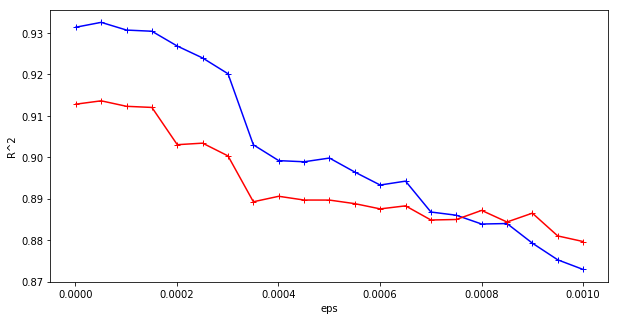

In [7]:
nlist=[]
las_scores=[]
las_scores2=[]
for i in np.linspace(0.000001,0.001,21):
    
    est = linear_model.LassoCV(eps=i,cv=5,random_state=5)
    ft = SelectFromModel(est) 

    # recursive feature elimination
    rf = RFECV(est, cv=5)

    df1 = ft.fit_transform(X_train1,y_train)
    df2 = rf.fit_transform(df1,y_train)
    
    #lasso_test.fit(X_train1,y_train)
    nlist.append(i)
    las_scores.append(rf.score(df1,y_train))
    las_scores2.append(rf.score(X_test1[X_train1.columns].loc[:,ft.get_support()],y_test))
plt.figure(figsize=(10,5))
plt.plot(nlist,las_scores,'b+-')
plt.plot(nlist,las_scores2,'r+-')
plt.xlabel('eps')
plt.ylabel('R^2')

plt.show()
#pd.DataFrame({'Score':[round(x,3) for x in las_scores]},index=[round(x, -int(floor(log10(x)))+1) for x in nlist])

In [8]:
display(pd.DataFrame({'ScoreTrain':[round(x,3) for x in las_scores],'ScoreTest':[round(x,3) for x in las_scores2]},index=[round(x, -int(floor(log10(x)))+1) for x in nlist]))

,ScoreTrain,ScoreTest
0.000001,0.931,0.913
0.000051,0.933,0.914
0.000100,0.931,0.912
0.000150,0.930,0.912
0.000200,0.927,0.903
0.000250,0.924,0.903
0.000300,0.920,0.900
0.000350,0.903,0.889
0.000400,0.899,0.891
0.000450,0.899,0.890


In general, smaller values of eps give better scores for the model. Smaller values of eps also result in more features returned for feature elimination. I want to find the best model while trying to avoid overfitting.  

The best score for the test set is when eps <= 0.00015. The graph shows the the scores are similar for the train and test sets for values of eps between 0.0007 and 0.00085.
For this version, I will use eps=0.00085. Larger values of eps generally result in simpler models.
I will test eps=0.00015 in another notebook and compare the two models.

In [9]:
#first reduce the number of features to speed up recursive feature elimination
est = linear_model.LassoCV(eps=0.00085,cv=5,random_state=5)
ft = SelectFromModel(est) 

# recursive feature elimination
rf = RFECV(est, cv=5)

print('Starting...')
df1 = ft.fit_transform(X_train1,y_train)
df2 = rf.fit_transform(df1,y_train)
print('Done')


Starting...
Done


In [10]:
#Use results of feature selection to create the new dataframes
selected_columns1 = ft.get_support()
X_train_selected = pd.DataFrame(data=df1, columns = X_train1.columns[selected_columns1],index=X_train1.index)
X_test = X_test1[X_train1.columns[selected_columns1]]

selected_columns2 = rf.get_support()
X_train = pd.DataFrame(data=df2, columns = X_train_selected.columns[selected_columns2],index=X_train1.index)
display(X_train.head())

,LotFrontage,OverallQual,OverallCond,YearRemodAdd,TotalBsmtSF,GrLivArea,GarageArea,WoodDeckSF,MSSubClass_20.0,MSSubClass_30.0,...,CentralAir_N,KitchenQual_Ex,KitchenQual_TA,Functional_Typ,FireplaceQu_nan,GarageType_Attchd,GarageFinish_Unf,GarageCond_TA,PavedDrive_Y,SaleCondition_Abnorml
Id,,,,,,,,,,,,,,,,,,,,,
255,0.000000,0.444444,0.625,0.116667,0.628912,-0.246035,-0.800000,1.488095,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1067,-0.523810,0.555556,0.750,0.733333,-0.394436,0.151644,-0.434043,0.000000,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
639,-0.142857,0.444444,0.750,0.000000,-0.400397,-1.047582,-2.051064,1.952381,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
800,-0.476190,0.444444,0.750,0.000000,-0.529558,0.456480,-1.029787,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
381,-0.952381,0.444444,0.625,0.000000,0.056632,0.337331,-0.740426,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


The feature selection methods, SelectFromModel and RFECV, selected 38 of the 344 features to use for the model.  
[SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)   
[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

Let's take a look at the coefficients that were returned by LassoCV and check for reasonableness.

In [11]:
# Get the coefficients for the model
est.fit(X_train,y_train)
with pd.option_context('display.max_rows', None):
    display(pd.DataFrame({'Coef':est.coef_},index=X_train.columns).sort_values('Coef', ascending=False))

,Coef
OverallQual,0.544636
OverallCond,0.203694
GrLivArea,0.151711
Exterior1st_BrkFace,0.103857
Neighborhood_Crawfor,0.095794
Functional_Typ,0.081117
YearRemodAdd,0.079093
BsmtExposure_Gd,0.078885
Neighborhood_NridgHt,0.063609
KitchenQual_Ex,0.060469


### 3. Testing the model

I created a custom cross-validation function that would allow me to fit the model without outliers and test with outliers.

In [12]:
#Function uses KFold to cross-valiadate model. 
#Custom CV function takes and option list of outlier indices to remove for fitting.
def cvScore(df1,y, outL=[]):
    scores = []
    kf = KFold(n_splits=4,shuffle =True,random_state=1)
    kfs = kf.split(df1.index)
    for train_index,test_index in kfs:
        #KFold returns indices between 0 and n-1. I needed to reset the index to get the correct rows for the sets.
        X_tr = df1.reset_index().loc[train_index,:]
        X_tr = X_tr.drop([idx[0] for idx in X_tr.iterrows() if idx[1][0] in outL])
        X_tr = X_tr.drop('Id', axis=1)
        
        X_tst = df1.reset_index(drop=True).loc[test_index,:]
        
        y_tr = y.reset_index().loc[train_index]
        y_tr = y_tr.drop([idx[0] for idx in y_tr.iterrows() if idx[1][0] in outL])
        y_tr = y_tr.drop('Id',axis=1)
        
        y_tst = y.reset_index(drop=True).loc[test_index]        
        
        est.fit(X_tr,y_tr)
        p = est.predict(X_tst)
        scores.append(round(np.sqrt(mean_squared_error(y_tst, p)),4))
    return scores

The y-values have already been converted to logarithms. I will use root mean square error, RMSE, to test the error for the model.  
[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [13]:
# Test the model using CV on training set
print('Train R^2:',rf.score(X_train_selected,y_train))

scores = cvScore(X_train,y_train)
error1 = round(np.mean(scores),4)
print("Scores:", scores, '\nAverage Train RMSE:', error1)
print("Accuracy: %0.2f (+/- %0.2f)" %(error1, np.std(scores) * 2))

Train R^2: 0.8840169075180163
Scores: [0.1839, 0.1262, 0.1404, 0.1346] 
Average Train RMSE: 0.1463
Accuracy: 0.15 (+/- 0.04)


In [14]:
#Test model using test set
print('Test R^2:', rf.score(X_test,y_test))

est.fit(X_train,y_train)
preds = est.predict(X_test[X_train.columns])
rmse1 = round(np.sqrt(mean_squared_error(y_test, preds)),4)
print('Test RSME:',rmse1)
display(pd.DataFrame({'Predicted Prices':np.around(np.e**preds,-2)},index=y_test.index)
       .join(pd.DataFrame({'Actual Prices':np.around(np.e**y_test,2)})).head())


Test R^2: 0.884387029308554
Test RSME: 0.1469


,Predicted Prices,Actual Prices
Id,,
893,157100.0,154500.0
1106,324700.0,325000.0
414,94400.0,115000.0
523,143700.0,159000.0
1037,347000.0,315500.0


### 4. Checking for outliers and retesting the model

Next I will check for outliers. I will use DBSCAN to cluster houses based on the features selected: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  

Houses not contained in the main cluster, Cluster 0, will be considered to be outliers. The appropriate value for epsilon for DBSCAN varies greatly depending on the features selected. Let's create a graph using various values for eps to see the percentage of individuals that are considered to be outliers.

In [15]:
#Function uses DBSCAN and various values for epsilon to calculate percent of datapoints identified as outliers
def eps_test(dfT):
    outliers1=[]
    eps_array = np.arange(0.1,6,0.1)
    for i in eps_array:
        check_outliers = DBSCAN(eps=i)
        clusters1 = check_outliers.fit_predict(dfT)
        outliers1.append(len([i for i in clusters1 if i != 0]))

    plt.figure(figsize=(10,5))
    plt.scatter(eps_array,[x/len(dfT.index)*100 for x in outliers1])
    plt.xlabel('eps')
    plt.ylabel('% identified as outliers')
    plt.show()
    #display(pd.DataFrame({'# outliers':outliers1, '% outliers':[x/len(dfT.index)*100 for x in outliers1]},index=eps_array))
    return

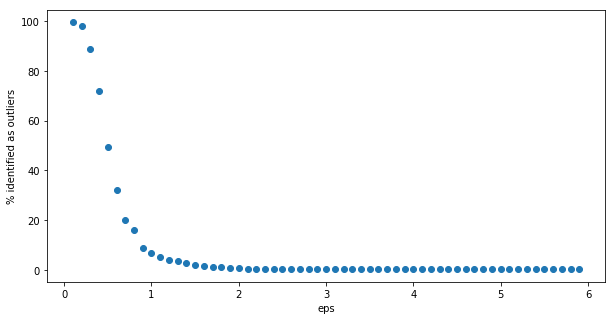

In [16]:
#Find features selected for the model that are continuous numeric features
num_feature_df = [colname for colname in X_train.columns if colname in numeric_cols]
#Call function to view percent of individuals considered to be outliers for various values of eps
eps_test(X_train[num_feature_df])

From the graph, it appears that less than 9% of the houses are outliers. 


The next function chooses an appropriate value for eps for DBSCAN using one of two methods.  
The first method finds the smallest value of eps such that all points not identified by DBSCAN as outliers, -1, are in a single cluster. If that algorithm results in a percentage of outliers above a given threshold, then eps is increased until the percentage threshold is reached.

In [17]:
#Function finds an epsilon value to use for dbscan
def get_eps(df,max_percent=9):
    eps=0
    j=0
    #Find eps to the nearest hundredth
    for p in range(3):
        for i in range(1,11):
            j = j + 1/(10**p)
            check_outliers = DBSCAN(eps=j)
            clusters = check_outliers.fit_predict(df)
            outliers_found = [i for i in clusters if i != 0]
            if ((len(np.unique(clusters)))<=2) and (len(outliers_found)<len(df.index)):
                if p != 2:
                    j = j-(1/(10**p))
                eps = j
                break
    eps = round(eps,2)        
    if eps > 0:
        print('Epsilon=',eps,', Outliers: ',len(outliers_found),', ',round(len(outliers_found)/len(clusters)*100,2),'%')
                                
                
    #If too many outliers identified or eps > 10 try another method using percentages
    if (len(outliers_found)/len(clusters)*100) >= max_percent or eps==0:
        print('eps=',eps,' Trying again...')
        for i in range(1,50):
            check_outliers = DBSCAN(eps=i)
            clusters = check_outliers.fit_predict(df)
            outliers_found = [i for i in clusters if i !=0]
            if (len(outliers_found)/len(clusters)*100) < max_percent:
                j = i-1
                for p in range(1,3):
                    for i in range(1,11):
                        j = j + 1/(10**p)
                        check_outliers = DBSCAN(eps=j)
                        clusters = check_outliers.fit_predict(df)
                        outliers_found = [i for i in clusters if i !=0]
                        if (len(outliers_found)/len(clusters)*100)<= max_percent:
                            if p != 2:
                                j = j-(1/(10**p))
                            eps = j
                            break
                break
        eps = round(eps,2)        
        print('Epsilon=',eps,', Outliers: ',len(outliers_found),', ',round(len(outliers_found)/len(clusters)*100,4),'%')
    return eps

In [18]:
#Use the function to try to find an appropriate value for epsilon for DBSCAN
eps = get_eps(X_train[num_feature_df])

Epsilon= 0.9 , Outliers:  101 ,  8.65 %


In [19]:
#check for outliers
check_outliers = DBSCAN(eps=eps)
clusters = check_outliers.fit_predict(X_train[num_feature_df])

results = pd.DataFrame({'Result':clusters,'Count':X_train[num_feature_df].index},index=X_train[num_feature_df].index)
display(results.groupby('Result').count())
outliers = results[results['Result'] !=0]
print('Outliers: ',outliers.shape[0],', ',outliers.shape[0]/results.shape[0]*100,'%')

,Count
Result,
-1,101
0,1067


Outliers:  101 ,  8.647260273972602 %


Next I will create scatterplots for the selected numeric features plotted against y, SalePrice, with points identified as potential outliers marked in red.

In [20]:
#Function creates graphs with potential outliers marked in red
def get_graphs(df,results,cols,cmap='bwr'):
    c=[]
    for i in df.index:
        if results['Result'][i] != 0:
            c.append(1)
        else:
            c.append(0)
    for col in cols:
        df.plot.scatter('SalePrice',col, c=c, colormap=cmap)
    return

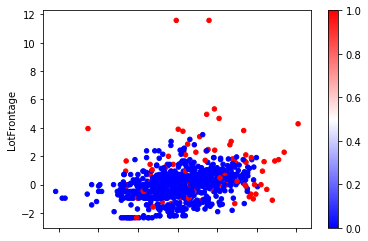

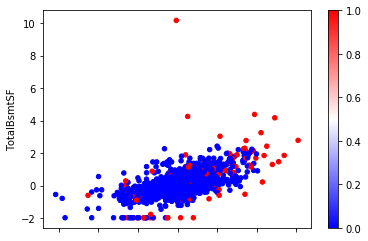

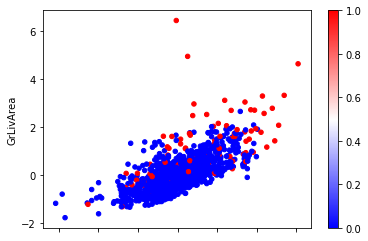

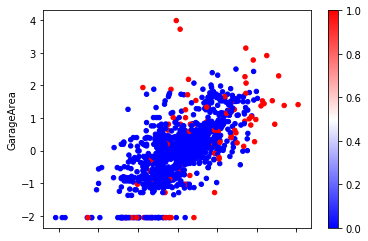

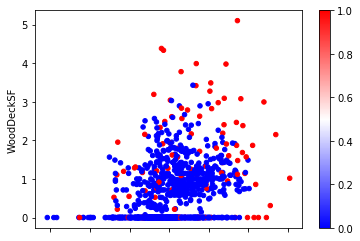

In [21]:
#Use funtion to create graphs
get_graphs(X_train.join(y_train),results, num_feature_df)

It appears that the outliers have been identified.

Next, retest the model without outliers.

In [22]:
#retest the model using training set CV fitted and tested without outliers

scores2 = cvScore(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]),
                  y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))
error2 = round(np.mean(scores2),4)

est.fit(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]),
        y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))

print('Train R^2:',est.score(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]),
                             y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)])))

print("Scores:", scores2, '\nAverage Train RMSE:', error2)
print('Original CV Train RMSE mean:',error1)
print("Accuracy: %0.2f (+/- %0.2f)" % (error2, np.std(scores2) * 2))

Train R^2: 0.9126365745513764
Scores: [0.1339, 0.0972, 0.1123, 0.1069] 
Average Train RMSE: 0.1126
Original CV Train RMSE mean: 0.1463
Accuracy: 0.11 (+/- 0.03)


Removing outliers improved the average RMSE.

Now check the score when fitting without outliers and predicting with outliers present.

In [23]:
#retest the model using training set CV fitted without outliers and tested with outliers

scores3 = cvScore(X_train,y_train,outliers.index)
error3 = round(np.mean(scores3),4)

est.fit(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]),
        y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))

print('Train R^2:',est.score(X_train,y_train))

print("Scores:", scores3, '\nAverage Train RMSE:', error3)
print('Original CV Train RMSE mean:',error1)
#save_errors.append([error1,error2, error3])
print("Accuracy: %0.2f (+/- %0.2f)" % (error3, np.std(scores3) * 2))
#save_errors

Train R^2: 0.8660661881339773
Scores: [0.1968, 0.1196, 0.1495, 0.1164] 
Average Train RMSE: 0.1456
Original CV Train RMSE mean: 0.1463
Accuracy: 0.15 (+/- 0.06)


No real improvement using the training set for cross-validation.

Let's see if the there is improvement using the test set.

In [24]:
# Test LassoCV again using test set by training without outliers
est.fit(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]),
        y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))

print('Test R^2:',est.score(X_test[X_train.columns],y_test))
preds = est.predict(X_test[X_train.columns])
rmse2 = round(np.sqrt(mean_squared_error(y_test, preds)),4)
print('RMSE:',rmse2,'\nOld RMSE:',rmse1)
display(pd.DataFrame({'Predicted Prices':np.around(np.e**preds,-2)},index=y_test.index)
        .join(pd.DataFrame({'Actual Prices':np.e**y_test})).head())

Test R^2: 0.8967552093144301
RMSE: 0.1388 
Old RMSE: 0.1469


,Predicted Prices,Actual Prices
Id,,
893,156800.0,154500.0
1106,349800.0,325000.0
414,97500.0,115000.0
523,147100.0,159000.0
1037,361700.0,315500.0


There is a bit of an improvement in the test score when fitting without the outliers. I will keep this model.

### 5. Testing ensemble methods

Now I'll try some ensemble methods to see if they will improve the model.  
[BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)  
[AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)  
[GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

In [25]:
from sklearn.ensemble import BaggingRegressor
be = BaggingRegressor(est, random_state=11)
be.fit(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)])
       ,y_train.drop([idx for idx in X_train.index if idx in list(outliers.index)]))
preds4 = be.predict(X_test[X_train.columns])
error4 = np.sqrt(mean_squared_error(y_test, preds4))
print('LASSO RSME:', rmse1, rmse2, 'BaggingRegressor RMSE:', round(error4,4))
print('Score train',be.score(X_train.drop([idx for idx in X_train.index if idx in list(outliers.index)])
       ,y_train.drop([idx for idx in X_train.index if idx in list(outliers.index)])),'Score test:',
     be.score(X_test[X_train.columns],y_test))

LASSO RSME: 0.1469 0.1388 BaggingRegressor RMSE: 0.14
Score train 0.912222163037093 Score test: 0.8950415186754215


In [26]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(est, random_state=11)
abr.fit(X_train1.drop([idx for idx in X_train.index if idx in list(outliers.index)]), 
       y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))
preds5 = abr.predict(X_test1[X_train1.columns])
error5 = np.sqrt(mean_squared_error(y_test, preds5))
print('LASSO RSME:', rmse1, rmse2, 'AdaBoostRegressor RMSE:', round(error5,4))
print('Score train',abr.score(X_train1.drop([idx for idx in X_train.index if idx in list(outliers.index)])
       ,y_train.drop([idx for idx in X_train.index if idx in list(outliers.index)])),'Score test:',
     abr.score(X_test1[X_train1.columns],y_test))

LASSO RSME: 0.1469 0.1388 AdaBoostRegressor RMSE: 0.1481
Score train 0.8881557271147782 Score test: 0.882510698530983


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=11)
gbr.fit(X_train1.drop([idx for idx in X_train.index if idx in list(outliers.index)]), 
       y_train.drop([idx for idx in y_train.index if idx in list(outliers.index)]))
preds6 = gbr.predict(X_test1[X_train1.columns])
error6 = np.sqrt(mean_squared_error(y_test, preds6))
print('LASSO RSME:', rmse1, rmse2, 'GradientBoostingRegressor RMSE:', round(error6,4))
print('Score train',gbr.score(X_train1.drop([idx for idx in X_train.index if idx in list(outliers.index)])
       ,y_train.drop([idx for idx in X_train.index if idx in list(outliers.index)])),'Score test:',
     gbr.score(X_test1[X_train1.columns],y_test))

LASSO RSME: 0.1469 0.1388 GradientBoostingRegressor RMSE: 0.1394
Score train 0.9657532094338396 Score test: 0.8958447351650344


None of the ensemble methods resulted in an improved model when using the default parameters.  
I will stick with the current model rather than investigating these models using new parameters.

### 6. Creating predictions

Retrain the model using the entire test set. In the previous steps, the given test set was split between a training set and a testing set. I will now use the chosen model and fit it using the entire given test set.

Starting...
Done


,LotArea,OverallQual,OverallCond,YearRemodAdd,TotalBsmtSF,GrLivArea,GarageArea,WoodDeckSF,MSSubClass_20.0,MSSubClass_30.0,...,Functional_Typ,FireplaceQu_nan,GarageType_Attchd,GarageFinish_Fin,GarageFinish_Unf,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleCondition_Abnorml
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.254076,0.666667,0.500,0.883333,-0.269652,0.380070,0.281573,0.000000,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.030015,0.555556,0.875,0.433333,0.538308,-0.312090,-0.082816,1.773810,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.437624,0.666667,0.500,0.866667,-0.142289,0.497489,0.530021,0.000000,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.017663,0.666667,0.500,0.333333,-0.468657,0.390885,0.670807,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
5,1.181201,0.777778,0.500,0.833333,0.305473,1.134029,1.474120,1.142857,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


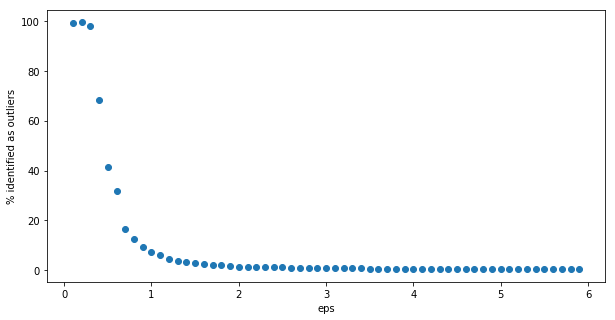

In [28]:
#Select features using entire test set and use recursive feature elimination
#ft is SelectFromModel object and rf is RFECV object
print('Starting...')
X1 = transform_data(X)
df1 = ft.fit_transform(X1,y)
df2 = rf.fit_transform(df1,y)
print('Done')

#Use results of feature selection to create the new dataframes
selected_columns1 = ft.get_support()
X_selected = pd.DataFrame(data=df1, columns = X1.columns[selected_columns1],index=X1.index)

selected_columns2 = rf.get_support()
X_New = pd.DataFrame(data=df2, columns = X_selected.columns[selected_columns2],index=X1.index)
display(X_New.head())

#check for outliers
num_feature_dfX = [colname for colname in X_New.columns if colname in numeric_cols]
eps_test(X_New[num_feature_dfX])


Epsilon= 1.21 , Outliers:  60 ,  4.11 %


,Count
Result,
-1,60
0,1400


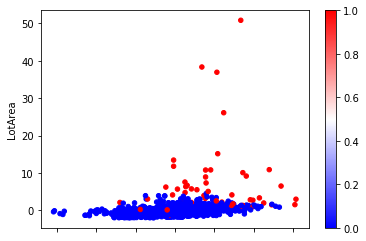

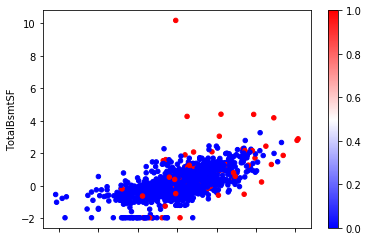

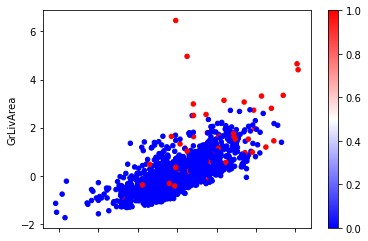

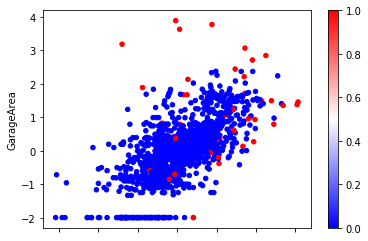

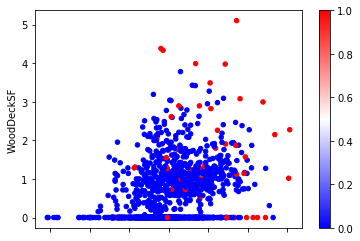

In [29]:
#Remove potential outliers
eps = get_eps(X1[num_feature_dfX],5)
check_outliers = DBSCAN(eps=eps)
clustersX = check_outliers.fit_predict(X1[num_feature_dfX])
resultsX = pd.DataFrame({'Result':clustersX,'Count':X1[num_feature_dfX].index},index=X1[num_feature_dfX].index)
display(resultsX.groupby('Result').count())
outliersX = resultsX[resultsX['Result'] !=0]
get_graphs(X1.join(y),resultsX, num_feature_dfX)


In [30]:
#Get scores for the new model
scoresX = cvScore(X_New,y,outliersX.index)
print("Scores:", scoresX, '\nAverage:', round(np.mean(scoresX),4))

#fit the model using all test data except potential outliers
est.fit(X_New.drop(outliersX.index), y.drop(outliersX.index))
print('R^2:', est.score(X_New,y))
pd.DataFrame({'Coef':est.coef_},index=X_New.columns).sort_values('Coef', ascending=False)
predsX = est.predict(X_New)
display(pd.DataFrame({'Predicted Prices':np.around(np.e**predsX,-2)},index=y.index)
        .join(pd.DataFrame({'Actual Prices':np.around(np.e**y,2)})).head())

Scores: [0.1234, 0.1992, 0.1428, 0.1159] 
Average: 0.1453
R^2: 0.8667406814850719


,Predicted Prices,Actual Prices
Id,,
1,201800.0,208500.0
2,186700.0,181500.0
3,222900.0,223500.0
4,176000.0,140000.0
5,288500.0,250000.0


In [31]:
#Get and transform the test data
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
display(df_test.head())

df_test = transform_data(df_test,'transform')

#Add in missing columns for predict. Some columns may have been added by one-hot-encoding only in test set.
missing = list(set(X_New.columns) - set(df_test.columns))
for col in missing:
    df_test[col]=np.zeros(len(df_test.index))
display(df_test.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.523810,0.529521,0.444444,0.625,0.644928,0.183333,0.000000,0.118638,144.0,-0.354701,...,0,1,0,0,0,0,0,1,0,0
1462,0.571429,1.182930,0.555556,0.625,0.623188,0.133333,0.650602,0.757459,0.0,-0.122222,...,0,1,0,0,0,0,0,1,0,0
1463,0.238095,1.074975,0.444444,0.500,0.905797,0.800000,0.000000,0.572131,0.0,-0.582051,...,0,1,0,0,0,0,0,1,0,0
1464,0.428571,0.123394,0.555556,0.625,0.913043,0.800000,0.120482,0.306774,0.0,-0.262393,...,0,1,0,0,0,0,0,1,0,0
1465,-1.238095,-1.105114,0.777778,0.500,0.869565,0.700000,0.000000,-0.169182,0.0,0.922222,...,0,1,0,0,0,0,0,1,0,0


In [32]:
#Use the test data and model to make predictions
est.fit(X_New.drop(outliersX.index), y.drop(outliersX.index))
test_preds = est.predict(df_test[X_New.columns])

#Convert values from logarithms back to sale prices
e_test_preds = np.e**test_preds
df_out = pd.DataFrame({'SalePrice':e_test_preds},index=df_test.index)
df_out.head()

,SalePrice
Id,
1461,124239.421745
1462,156329.362023
1463,185183.961504
1464,197007.744219
1465,187128.027695


In [33]:
#Check that we have the expected number of rows
df_out.shape

(1459, 1)

In [34]:
#Create the file with predictions
df_out.to_csv('results.csv')